# Dealing With Missing Values

We typically see missing values as the blank spaces in our data table or as placeholder strings such as NaN
(Not A Number).

Unfortunately, most computational tools are unable to handle such missing values
or would produce unpredictable results if we simply ignored them. Therefore, it
is crucial that we take care of those missing values before we proceed with further
analyses. 

In [38]:
import pandas as pd
from io import StringIO
csv_data = '''A, B, C, D
            1.0, 2.0, 3.0, 4.0
            5.0, 6.0,,7.0
            0.0, 11.0, 10.0'''
# csv_data = str(csv_data)
df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1,2,3,4
1,5,6,NaN,7
2,0,11,10,NaN


For a larger DataFrame, it can be tedious to look for missing values manually; in this
case, we can use the isnull method to return a DataFrame with Boolean values that
indicate whether a cell contains a numeric value (False) or if data is missing (True).
Using the sum method, we can then return the number of missing values per column
as follows

In [39]:
# df.isnull()
df.isnull().sum()

A     0
 B    0
 C    1
 D    1
dtype: int64

Although scikit-learn was developed for working with NumPy arrays, it can sometimes be more 
convenient to preprocess data using pandas' DataFrame. We can always access the underlying
NumPy array of the DataFrame via the values attribute before we feed it into a scikit-learn
estimator

In [40]:
df.values

array([[  1.,   2.,   3.,   4.],
       [  5.,   6.,  nan,   7.],
       [  0.,  11.,  10.,  nan]])

### Eliminating samples or features with missing values

One of the easiest ways to deal with missing data is to simply remove the corresponding features (columns) or samples (rows) from the dataset entirely; rows with missing values can be easily dropped via the dropna method

In [41]:
df.dropna()

,A,B,C,D
0,1,2,3,4


We can drop columns that have at least one NaN in any row by setting the axis argument to 1:

In [42]:
df.dropna(axis = 1)

,A,B
0,1,2
1,5,6
2,0,11


The dropna method supports several additional parameters as shown

In [43]:
#drop rows where all columns are NAs
df.dropna(how = 'all')

,A,B,C,D
0,1,2,3,4
1,5,6,NaN,7
2,0,11,10,NaN


In [44]:
#drop rows where atleast two columns are NAs
df.dropna(thresh = 4)

,A,B,C,D
0,1,2,3,4


In [45]:
#drop rows where there are values missing in a particular column
df.dropna(subset = ['A'])

,A,B,C,D
0,1,2,3,4
1,5,6,NaN,7
2,0,11,10,NaN


### Imputing missing values

One of the most common interpolation techniques is mean imputation, where we simply replace the missing value by the mean value of the entire feature column.

In [46]:
from sklearn.preprocessing import Imputer
imr = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
imr = imr.fit(df)
imputed_data = imr.transform(df.values)
imputed_data

array([[  1. ,   2. ,   3. ,   4. ],
       [  5. ,   6. ,   6.5,   7. ],
       [  0. ,  11. ,  10. ,   5.5]])

The Imputer class belongs to the so-called transformer classes in scikit-learn that are used for data transformation. The two essential methods of those estimators are fit and transform. The fit method is used to learn the parameters from the training data, and the transform method uses those parameters to transform the data. Any data array that is to be transformed needs to have the same number of features as the data array that was used to fit the model.

# Handling categorical data

When we are talking about categorical data, we have to further distinguish between nominal and ordinal features. Ordinal features can be understood as categorical values that can be sorted or ordered. In contrast, nominal features don't imply any order. 

In [47]:
import pandas as pd
df = pd.DataFrame([
        ['green', 'M', 10.1, 'class1'], 
        ['blue', 'L', 15.0, 'class2'], 
        ['red', 'XL', 20.5, 'class3']
    ])
df.columns = ['color', 'size', 'price', 'classLabel']
df

,color,size,price,classLabel
0,green,M,10.1,class1
1,blue,L,15.0,class2
2,red,XL,20.5,class3


### Mapping ordinal features

In [48]:
size_mapping = {'XL': 3, 'L': 2, 'M': 1}
df['size'] = df['size'].map(size_mapping)
df

,color,size,price,classLabel
0,green,1,10.1,class1
1,blue,2,15.0,class2
2,red,3,20.5,class3


In [49]:
inv_size_mapping = {v : k for k,v in size_mapping.items()}
df['size'] = df['size'].map(inv_size_mapping)
df

,color,size,price,classLabel
0,green,M,10.1,class1
1,blue,L,15.0,class2
2,red,XL,20.5,class3


### Encoding class labels

The class labels are not ordinal, and it doesn't matter which integer number we assign to a particular string-label.

In [50]:
import numpy as np
class_mapping = {label:idx for idx, label in enumerate(np.unique(df['classLabel']))}
class_mapping

{'class1': 0, 'class2': 1, 'class3': 2}

In [51]:
df['classLabel'] = df['classLabel'].map(class_mapping)
df

,color,size,price,classLabel
0,green,M,10.1,0
1,blue,L,15.0,1
2,red,XL,20.5,2


In [52]:
inv_class_mapping = {v : k for k, v in class_mapping.items()}
df['classLabel'] = df['classLabel'].map(inv_class_mapping)
df

,color,size,price,classLabel
0,green,M,10.1,class1
1,blue,L,15.0,class2
2,red,XL,20.5,class3


In [53]:
from sklearn.preprocessing import LabelEncoder
class_le = LabelEncoder()
y = class_le.fit_transform(df['classLabel'].values)
y

array([0, 1, 2])

In [54]:
class_le.inverse_transform(y)

array(['class1', 'class2', 'class3'], dtype=object)

### Performing one-hot encoding on nominal features

In [55]:
X = df[['color', 'price']].values
color_le = LabelEncoder()
X[:, 0] = color_le.fit_transform(X[:, 0])
X

array([[1, 10.1],
       [0, 15.0],
       [2, 20.5]], dtype=object)

The idea behind one-hot encoding approach is to create a new dummy feature for each unique value in the nominal feature column.

In [56]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(categorical_features= [1])
ohe.fit_transform(X).toarray()

array([[ 1.,  0.,  0.,  1.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  2.]])

In [57]:
X = df[['color', 'price']].values
color_le = LabelEncoder()
X[:, 0] = color_le.fit_transform(X[:, 0])

from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(categorical_features= [1], sparse = False)
ohe.fit_transform(X)

array([[ 1.,  0.,  0.,  1.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  2.]])

In [58]:
import pandas as pd
pd.get_dummies(df[['price', 'size', 'color']])

,price,size_L,size_M,size_XL,color_blue,color_green,color_red
0,10.1,0,1,0,0,1,0
1,15.0,1,0,0,1,0,0
2,20.5,0,0,1,0,0,1


### Partitioning a dataset in training and test sets

In [59]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', 
                     header = None)
df_wine.columns = ['Class Label', 'Alcohol', 'Malic Acid', 'Ash', 
                   'Alcanility of ash', 'Magnesium', 'Total phenols', 
                  'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 
                  'Color Intensity', 'Hue', 'OD280/OD315 of diluted wines', 
                  'Proline']
print ('Class labels:', np.unique(df_wine['Class Label']))
df_wine.head()


Class labels: [1 2 3]


,Class Label,Alcohol,Malic Acid,Ash,Alcanility of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color Intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [60]:
from sklearn.cross_validation import train_test_split
X = df_wine.iloc[:, 1:].values
y = df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, 
                                                   random_state = 1)

### Bringing features onto the same scale

Feature scaling is a crucial step in our preprocessing pipeline that can easily be forgotten. Decision trees and random forests are one of the very few machine learning algorithms where we don't need to worry about feature scaling. However, the majority of machine learning and optimization algorithms behave much better if features are on the same scale.

There are two common approaches to bringing different features onto the same scale: normalization and standardization. Normalization refers to the rescaling of the features to a range of [0, 1], which is a special case of min-max scaling.

In [61]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

Although normalization via min-max scaling is a commonly used technique that is useful when we need values in a bounded interval, standardization can be more practical for many machine learning algorithms. The reason is that many linear models, such as the logistic regression and SVM initialize the weights to 0 or small random values close to 0. Using standardization, we center the feature columns at mean 0 with standard deviation 1 so that the feature columns take the form of a normal distribution, which makes it easier to learn the weights. Furthermore, standardization maintains useful information about outliers and makes the
algorithm less sensitive to them in contrast to min-max scaling, which scales the data to a limited range of values.

In [62]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

# Selecting meaningful features

### Sparse solutions with L1 regularization

In [63]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty = 'l1', C = 0.1)
lr.fit(X_train_std, y_train)
print ('Training accuracy:', lr.score(X_train_std, y_train))
print ('Test accuracy:', lr.score(X_test_std, y_test))

Training accuracy: 0.991935483871
Test accuracy: 0.981481481481


In [64]:
lr.intercept_

array([-0.60946119, -0.00292097, -0.65749107])

In [65]:
lr.coef_

array([[ 0.19064698,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.45419774,  0.        ,  0.        ,  0.        ,
         0.        ,  0.11514524,  1.35833785],
       [-0.60623915, -0.04527957, -0.1210079 ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.71500539,
         0.25165221,  0.        , -0.63266569],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.79066707,  0.        ,  0.        ,  0.59410568,
        -0.46354355, -0.3092941 ,  0.        ]])

### Sequential feature selection algorithms

An alternative way to reduce the complexity of the model and avoid overfitting is dimensionality reduction via feature selection, which is especially useful for unregularized models. There are two main categories of dimensionality reduction techniques: feature selection and feature extraction. Using feature selection, we select a subset of the original features. In feature extraction, we derive information from the feature set to construct a new feature subspace. 

Sequential feature selection algorithms are a family of greedy search algorithms that are used to reduce an initial d-dimensional feature space to a k-dimensional feature subspace where k < d. A classic sequential feature selection algorithm is Sequential Backward Selection (SBS).

In [66]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

class SBS():
    def __init__(self, estimator, k_features, scoring = accuracy_score, test_size = 0.25, 
                 random_state = 0):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
        
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = self.test_size, 
                                                           random_state = self.random_state)
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score (X_train, X_test, y_train, y_test, self.indices_)
        self.scores_ = [score]
        
        while dim > self.k_features:
            scores = []
            subsets = []
            
            for p in combinations(self.indices_, r = dim - 1):
                score = self._calc_score(X_train, X_test, y_train, y_test, p)
                scores.append(score)
                subsets.append(p)
            
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            self.scores_.append(scores[best])
            
        self.k_score_ = self.scores_[-1]
        return self
    
    def transform(self, X):
        return X[:, self.indices_]
    
    def _calc_score(self, X_train, X_test, y_train, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

/Users/admin/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/admin/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


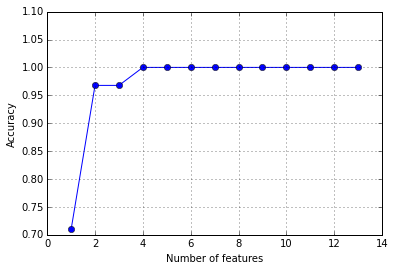

In [67]:
%matplotlib inline
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
knn = KNeighborsClassifier(n_neighbors = 2)
sbs = SBS(knn, k_features = 1)
sbs.fit(X_train_std, y_train)
k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat, sbs.scores_, marker = 'o')
plt.ylim([0.7, 1.1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.show()

In [68]:
k5 = list(sbs.subsets_[8])
print(df_wine.columns[1:][k5])

Index(['Alcohol', 'Ash', 'Alcanility of ash', 'Flavanoids', 'Proanthocyanins'], dtype='object')


In [69]:
knn.fit(X_train_std, y_train)
print ('Training accuracy:', knn.score(X_train_std, y_train))
print ('Test accuracy:', knn.score(X_test_std, y_test))

Training accuracy: 0.959677419355
Test accuracy: 0.962962962963


In [70]:
knn.fit(X_train_std[:, k5], y_train)
print('Training accuracy:', knn.score(X_train_std[:, k5], y_train))
print('Test accuracy:', knn.score(X_test_std[:, k5], y_test))

Training accuracy: 0.951612903226
Test accuracy: 1.0


A good summary about feature selection algorithms with illustrative examples can be found at http://scikitlearn.org/stable/modules/feature_selection.html.

# Assessing feature importance with random forests

Using a random forest, we can measure feature importance as the averaged impurity decrease computed from all decision trees in the forest without making any assumptions whether our data is linearly separable or not. 

In [71]:
from sklearn.ensemble import RandomForestClassifier
feat_labels = df_wine.columns[1:]
forest = RandomForestClassifier(n_estimators = 10, random_state = 0, 
                               n_jobs = -1)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print ('%2d) %-*s %f' %(f + 1, 30, feat_labels[f], importances[indices[f]]))

 1) Alcohol                        0.286411
 2) Malic Acid                     0.165227
 3) Ash                            0.124325
 4) Alcanility of ash              0.096339
 5) Magnesium                      0.058644
 6) Total phenols                  0.058626
 7) Flavanoids                     0.057690
 8) Nonflavanoid phenols           0.047295
 9) Proanthocyanins                0.034973
10) Color Intensity                0.023413
11) Hue                            0.020472
12) OD280/OD315 of diluted wines   0.014063
13) Proline                        0.012524


/Users/admin/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/admin/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/admin/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/admin/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/admin/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use insp

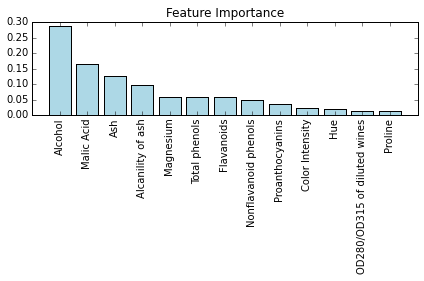

In [73]:
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[indices], color = 'lightblue', 
       align = 'center')
plt.xticks(range(X_train.shape[1]), feat_labels, rotation = 90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

In [76]:
X_selected = forest.transform(X_train, threshold=0.10)
X_selected.shape

(124, 3)